# Analysis part - Charizard___Holo_1999_Base_Set

In [23]:
library(ggplot2)
library(quantreg)


df = read.csv('lagged_merged_datasets_final/merged_Charizard___Holo_1999_Base_Set.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock and adjclosebond (including their lags) to returns
stock_bond_cols <- grep("adjclose(stock|bond)(lag[0-9]+)?", names(df), value = TRUE)

for(col in stock_bond_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))
}

#convert volume and its lags to 'returns'
volume_cols <- grep("volume(lag[0-9]+)?", names(df), value = TRUE)

for(col in volume_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))  
}


df <- na.omit(df)

print(head(df))


        date grade4price grade5price grade6price grade7price grade8price
2 2016-10-01          26       50.00      38.000        41.0     65.5175
3 2016-11-01          26       50.00      43.670        34.0     63.6925
4 2016-12-01          26       50.00      58.335        34.0     64.3500
5 2017-01-01          26       96.25      58.335        34.0     53.0000
6 2017-02-01          26       96.25      38.000        63.4     58.0540
7 2017-03-01          26       96.25      38.000        48.0     55.0000
  grade9price grade10price adjclosestock      volume adjclosebond  stockreturns
2    127.1250     775.0000       2126.15 72915530000        2.589 -0.0194256789
3    125.0000     775.0000       2198.81 88445380000        3.017  0.0341745218
4    189.4320     640.9950       2238.83 75344550000        3.063  0.0182007624
5    105.0000     625.0000       2278.87 70576420000        3.051  0.0178843582
6    114.7100     592.3333       2363.64 69260940000        2.968  0.0371981601
7    109.

                         grade4price_return grade5price_return
grade4price_return             1.000000e+00       0.3270224255
grade5price_return             3.270224e-01       1.0000000000
grade6price_return             8.193147e-02       0.1438217908
grade7price_return             3.083891e-01       0.1434923935
grade8price_return             2.538292e-01       0.2756048661
grade9price_return             3.199740e-01       0.2954796825
grade10price_return            5.151324e-01       0.4364424783
adjclosestock_return           1.563824e-01      -0.0821480305
adjclosebond_return            1.507690e-01       0.0001988534
adjclosestocklag1_return      -2.021756e-01       0.0249814078
adjclosebondlag1_return       -2.003346e-01      -0.0686272990
adjclosestocklag2_return      -1.034224e-01      -0.0479815600
adjclosebondlag2_return        1.739664e-01       0.1980532511
adjclosestocklag3_return       1.339758e-01       0.0765084321
adjclosebondlag3_return       -2.811302e-01      -0.101

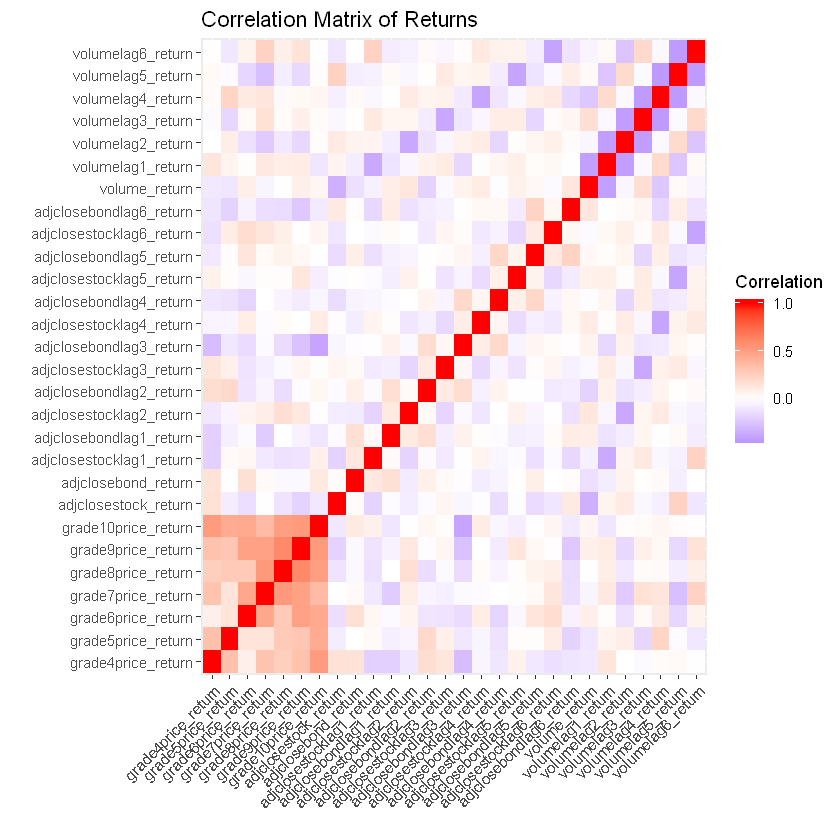

In [24]:
createReturnsCorrelationMatrix <- function(df) {
  # Load necessary libraries
  library(ggplot2)
  library(reshape2)
  
  # Use a simplified pattern to include both "_return" columns and any "volume" columns
  pattern <- "_return"
  selected_columns <- grep(pattern, names(df), value = TRUE)
  
  # Calculate the correlation matrix for the selected columns
  correlation_matrix <- cor(df[, selected_columns], use = "complete.obs")
  
  # Print the correlation matrix to the console
  print(correlation_matrix)
  
  # Melt the correlation matrix for visualization
  melted_correlation_matrix <- melt(correlation_matrix)
  
  # Create the ggplot object for the correlation matrix
  plot <- ggplot(data = melted_correlation_matrix, aes(x=Var1, y=Var2, fill=value)) +
    geom_tile() +
    scale_fill_gradient2(midpoint=0, low="blue", high="red", mid="white") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x='', y='', title='Correlation Matrix of Returns', fill='Correlation')
  
  # Explicitly print the ggplot object to ensure it's displayed
  print(plot)
  
  # Return the correlation matrix as well
  return(correlation_matrix)
}

# Assuming your adjusted dataset is in 'df'
# Example usage:
correlation_matrix <- createReturnsCorrelationMatrix(df)


## VAR model - try later - if enough time...

## Visualisation

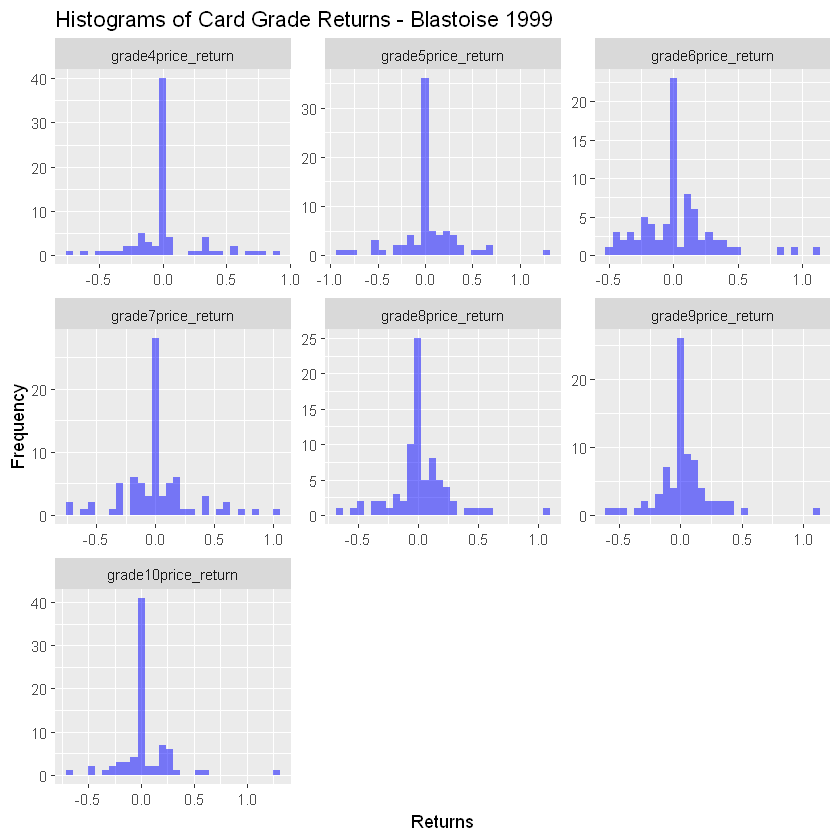

In [25]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

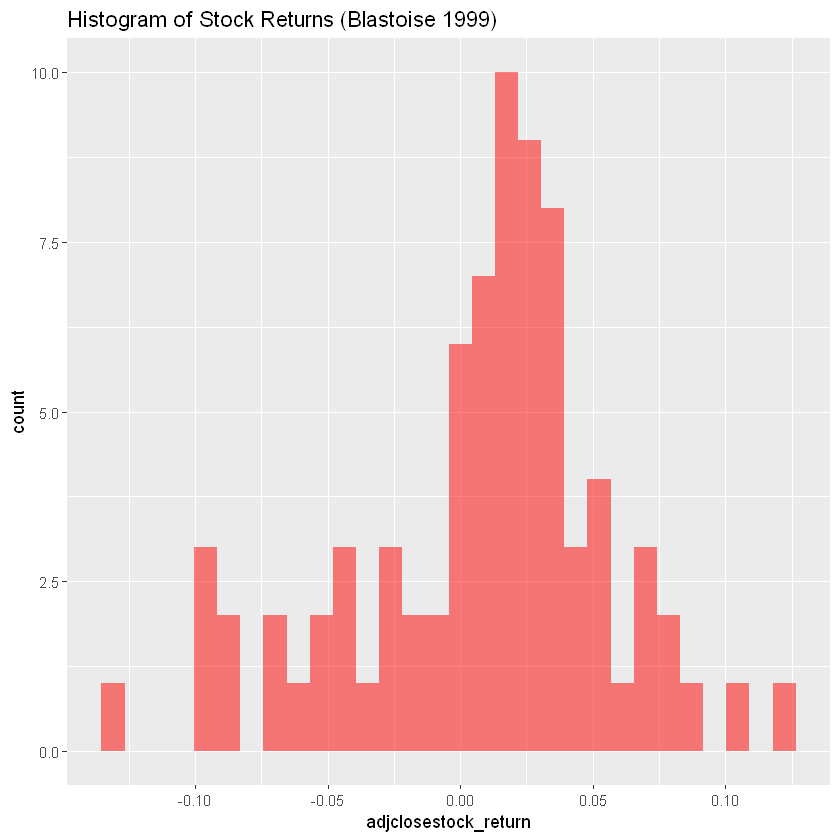

In [26]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

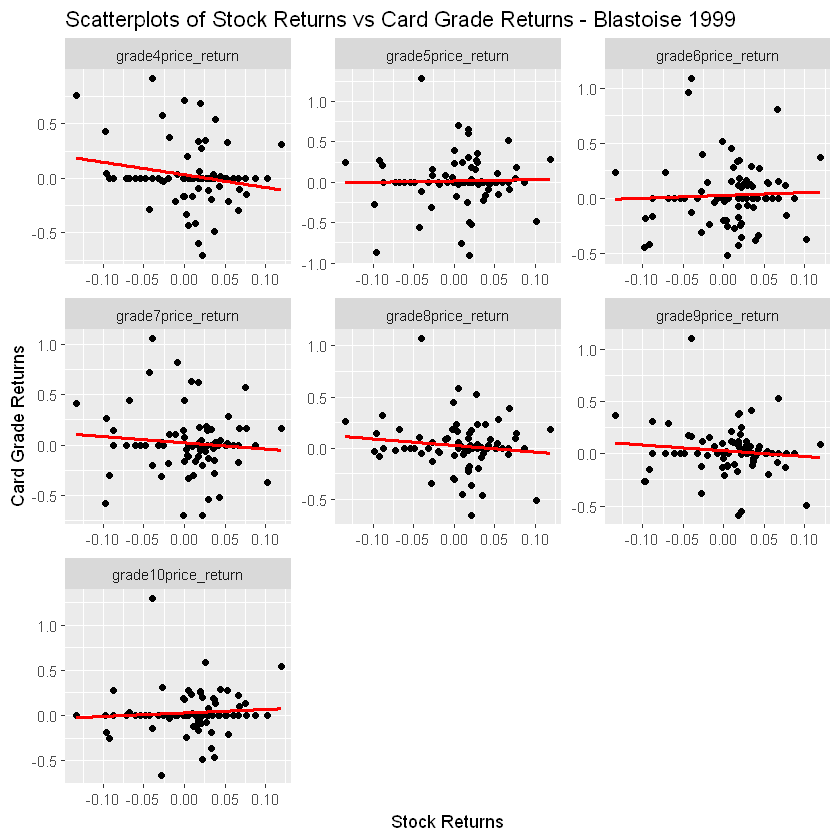

In [27]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestocklag1_return"), measure.vars = grade_returns) #ADJUST FOR DIFFERENT LAGS

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestocklag1_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Choose the variables using AIC

In [28]:

# Load necessary library
library(stats)

# Preparing the initial full model with the dependent variable (choosing one of the grade prices as an example)
# and all potential independent variables (using returns and lagged returns)
# Note: Adjust 'grade5price' to the specific grade price return you are analyzing
full_model <- lm(grade10price_return ~ adjclosestock_return + adjclosebond_return +
                 adjclosestocklag1_return + adjclosebondlag1_return +
                 adjclosestocklag2_return + adjclosebondlag2_return +
                 adjclosestocklag3_return + adjclosebondlag3_return +
                 adjclosestocklag4_return + adjclosebondlag4_return +
                 adjclosestocklag5_return + adjclosebondlag5_return +
                 adjclosestocklag6_return + adjclosebondlag6_return +
                 volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
                 volumelag4_return + volumelag5_return + volumelag6_return, data = df)

# Perform backward elimination based on AIC
reduced_model <- step(full_model, direction = "backward")

# Display the summary of the reduced model to see the selected variables and their coefficients
summary(reduced_model)


Start:  AIC=-206.24
grade10price_return ~ adjclosestock_return + adjclosebond_return + 
    adjclosestocklag1_return + adjclosebondlag1_return + adjclosestocklag2_return + 
    adjclosebondlag2_return + adjclosestocklag3_return + adjclosebondlag3_return + 
    adjclosestocklag4_return + adjclosebondlag4_return + adjclosestocklag5_return + 
    adjclosebondlag5_return + adjclosestocklag6_return + adjclosebondlag6_return + 
    volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
    volumelag4_return + volumelag5_return + volumelag6_return

                           Df Sum of Sq    RSS     AIC
- volume_return             1   0.00014 3.1536 -208.24
- adjclosestocklag5_return  1   0.00049 3.1540 -208.23
- adjclosebondlag5_return   1   0.00058 3.1541 -208.22
- volumelag6_return         1   0.00319 3.1567 -208.16
- volumelag3_return         1   0.00479 3.1583 -208.12
- adjclosestocklag3_return  1   0.00624 3.1598 -208.09
- adjclosestocklag2_return  1   0.00715 3.160


Call:
lm(formula = grade10price_return ~ adjclosebondlag2_return + 
    adjclosebondlag3_return + adjclosestocklag4_return + volumelag1_return, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56731 -0.11058 -0.00666  0.10358  1.00423 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.03069    0.02535   1.211   0.2300    
adjclosebondlag2_return   0.40745    0.29005   1.405   0.1643    
adjclosebondlag3_return  -1.26880    0.29505  -4.300  5.2e-05 ***
adjclosestocklag4_return  0.76371    0.53078   1.439   0.1545    
volumelag1_return        -0.29397    0.15981  -1.839   0.0699 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2192 on 73 degrees of freedom
Multiple R-squared:  0.2213,	Adjusted R-squared:  0.1786 
F-statistic: 5.186 on 4 and 73 DF,  p-value: 0.0009853


## Models

### OLS

In [29]:
#OLS
ols_model <- lm(grade10price_return ~ adjclosebondlag2_return + 
    adjclosebondlag3_return + adjclosestocklag4_return + volumelag1_return, data = df) 

print(summary(ols_model))

library(car)

# Calculate VIF
vif_result <- vif(ols_model)
print(vif_result)

library(lmtest)

# Perform the Breusch-Pagan test
bp_test <- bptest(ols_model)

# Print the test results
print(bp_test)



Call:
lm(formula = grade10price_return ~ adjclosebondlag2_return + 
    adjclosebondlag3_return + adjclosestocklag4_return + volumelag1_return, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56731 -0.11058 -0.00666  0.10358  1.00423 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.03069    0.02535   1.211   0.2300    
adjclosebondlag2_return   0.40745    0.29005   1.405   0.1643    
adjclosebondlag3_return  -1.26880    0.29505  -4.300  5.2e-05 ***
adjclosestocklag4_return  0.76371    0.53078   1.439   0.1545    
volumelag1_return        -0.29397    0.15981  -1.839   0.0699 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2192 on 73 degrees of freedom
Multiple R-squared:  0.2213,	Adjusted R-squared:  0.1786 
F-statistic: 5.186 on 4 and 73 DF,  p-value: 0.0009853

 adjclosebondlag2_return  adjclosebondlag3_return adjclosestocklag4_return 
         

Here no heteroskedasticity...according to B-P

### Quantile regression

In [30]:
#Quantile regression
library(quantreg)

quantile_model <- rq(grade10price_return ~ adjclosebondlag2_return + 
    adjclosebondlag3_return + adjclosestocklag4_return + volumelag1_return, data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
                                                                                                                                   

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step




#### Results for different quantiles of the grade 10 prices x OLS estimates (red line) 

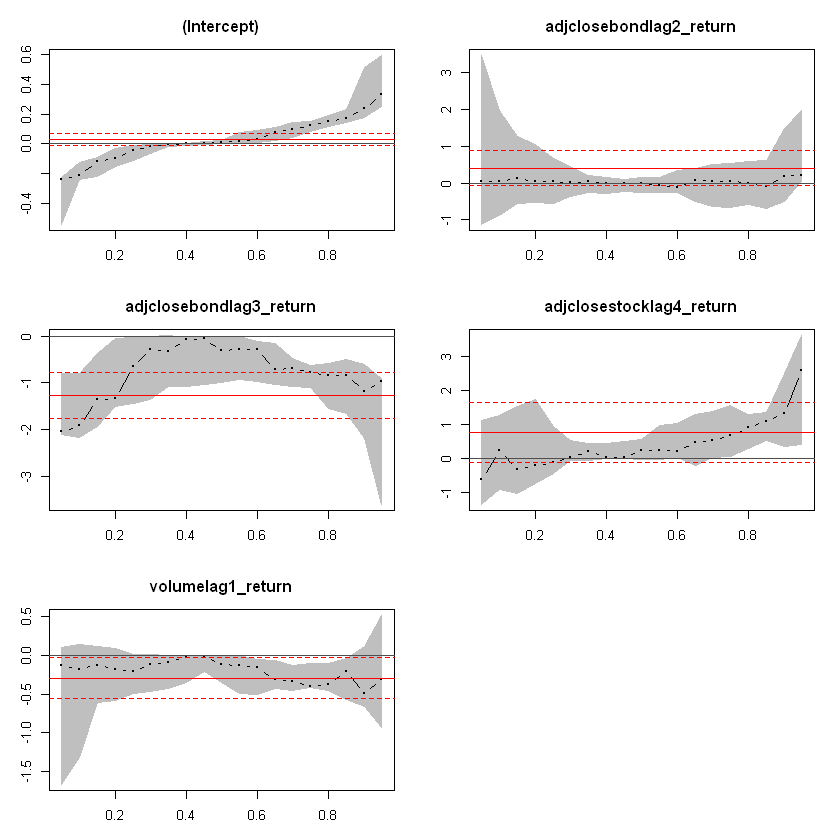

In [31]:

plot(summary(quantile_model))
